In [13]:
import os

import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from glob import glob
import pydicom as dicom
from skimage.segmentation import clear_border
from skimage.morphology import binary_closing, disk
from skimage.morphology import remove_small_objects
from skimage.measure import label,regionprops

In [57]:
## Load Data. keep slash notation for directories
testDir = r"C:\Users\Ann\Downloads\stage_2_test_images"
trainDir = r"C:\\Users\\Ann\\Downloads\\stage_2_train_images\\"

#get len of test and train folders, should be 3000, ~26,000
def filelen(dir):
    count = 0
    for path in os.listdir(dir):
        # check if current path is a file
        if os.path.isfile(os.path.join(dir, path)):
            count += 1
    return count
#test
print(filelen(testDir),filelen(trainDir))

#puts all file names in an array 
def dir2Array(dir):
    returnarr = [None] * filelen(dir)
    count = 0
    if dir == "trainDir":
        for entry in os.scandir(dir):
            if entry.is_file():
                returnarr[count] = dicom.dcmread(f"{entry.path}")
            count = count + 1
        return returnarr
    else:
        for entry in os.scandir(dir):
            if entry.is_file():
                returnarr[count] = dicom.dcmread(f"{entry.path}").pixel_array
            count = count + 1
        return returnarr
    #plot images using this repeatedly for testing

def plotImgs(arr,row,col,true):
    fig,axes = plt.subplots(row,col)
    if true == True:
        for i, ax in enumerate(axes.flat):
            ax.imshow(arr[i].pixel_array, cmap = plt.cm.gray) 
            ax.axis('off') 
    else:
        for i, ax in enumerate(axes.flat):
            ax.imshow(arr[i], cmap = plt.cm.gray) 
            ax.axis('off') 
    plt.tight_layout()
    plt.show()

# #potentially will be x rows by 6 cols
# patientId _- A patientId. Each patientId corresponds to a unique image. # x_ - the upper-left x coordinate of the bounding box. # y_ - the upper-left y coordinate of the bounding box.
# width_ - the width of the bounding box. # height_ - the height of the bounding box.
# Target_ - the binary Target, indicating whether this sample has evidence of pneumonia.
def loadLabels():
# using loadtxt()
    arr = np.loadtxt("stage_2_train_labels.csv",
                    delimiter=",", dtype=str)
    display(arr)
    return arr


3000 8


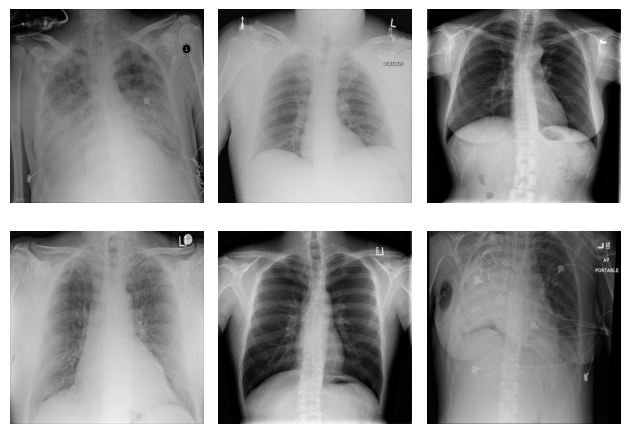

array([['patientId', 'x', 'y', 'width', 'height', 'Target'],
       ['0004cfab-14fd-4e49-80ba-63a80b6bddd6', '', '', '', '', '0'],
       ['00313ee0-9eaa-42f4-b0ab-c148ed3241cd', '', '', '', '', '0'],
       ...,
       ['c1f6b555-2eb1-4231-98f6-50a963976431', '', '', '', '', '0'],
       ['c1f7889a-9ea9-4acb-b64c-b737c929599a', '570.0', '393.0',
        '261.0', '345.0', '1'],
       ['c1f7889a-9ea9-4acb-b64c-b737c929599a', '233.0', '424.0',
        '201.0', '356.0', '1']], dtype='<U36')

0


In [64]:
# run separately for time
testds = dir2Array(testDir)
trainds = dir2Array(trainDir)
plotImgs(ans,2,3,"True")
labels = loadLabels()
print(labels[1,5])

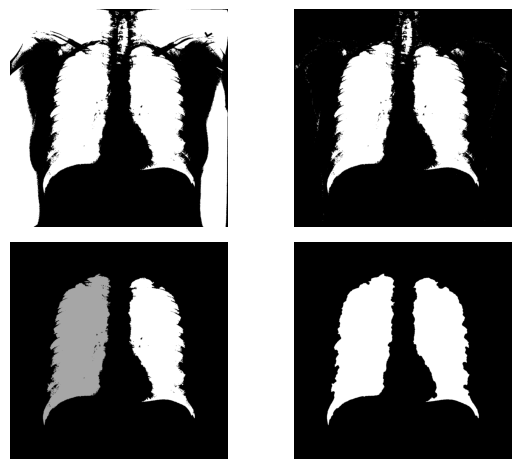

243411


In [66]:
#Segmentation and filtering
image = testds[0].astype(float)

def ridTrach(cleared):
    label_img = label(cleared)
    numregion = len(regionprops(label_img))
    regions = (regionprops(label_img))
    idxsize = 5000
    while numregion != 2:
        if numregion > 2:
            idxsize = idxsize + 1000
            label_img = remove_small_objects(label_img, min_size = idxsize)
            numregion = len(regionprops(label_img))
        elif numregion == 2:
            idxsize = idxsize
            label_img = remove_small_objects(label_img, min_size = idxsize)
        else:
            print("you messed up")
        break
    return label_img,regions

#segmentation for top part of lung
def segLungTop(img):
    thresh_val = 115
    binary_image = img < thresh_val
    cleared = clear_border(binary_image)
    #remove trachea and small holes
    filtered,regions = ridTrach(cleared)
    # #smooteh image
    smoothed = binary_closing(filtered, footprint=disk(5))
    array2plot  = [binary_image,cleared,filtered,smoothed]
    return smoothed,regions, array2plot

def getarea(boolimg):
    return boolimg.sum()

finimg,regions,imgarray = segLungTop(image)
lungarea = getarea(finimg)
plotImgs(imgarray,2,2,"f")
print(lungarea)

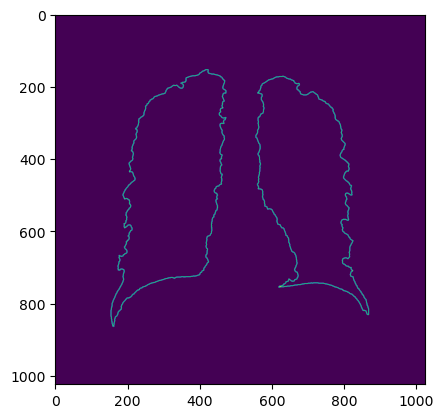

In [97]:
import skimage as ski
img = ski.filters.sobel(finimg)
plt.imshow(img)

In [119]:
intfinimg = np.array(finimg, dtype = np.uint8)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


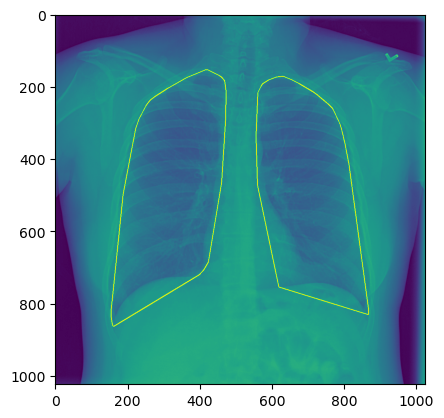

In [120]:
from PIL import Image, ImageFilter
import scipy as sci

contours, hierarchy = cv2.findContours(intfinimg, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
for contour in contours:
    perimeter = cv2.arcLength(contour, True)
    approximatedShape = cv2.approxPolyDP(contour, 0.02 * perimeter, True)
for contour in contours:
    convexHull = cv2.convexHull(contour)
    cv2.drawContours(image, [convexHull], -1, (255, 0, 0), 2)

# Display the final convex hull image

plt.imshow(image)

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model

#Start Batch normalization
x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
print('shape3',x.shape)

#Actual Perceptron starts below:
x = Flatten()(x) 
x = Dropout(0.2)(x)#prevents overfitting
# relu is a linear function(closest to step function)
# Kernel initializer creates weights
x = Dense(1024, activation='relu',kernel_initializer='glorot_uniform')(x)
x = Dropout(0.2)(x)
# sigmoid is the sinusoid function with more weights
x = Dense(K, activation='sigmoid',kernel_initializer='glorot_uniform')(x)


In [ ]:
model = Model(i, x)

In [ ]:
#adam is a stochastic grad. descent method that works better for large(>1000s) datasets
#This is the only model that works on my computer w. ~92% accuracy.
#with unlimited compute power however, I'd change epochs = 50 to achieve better results.
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
r = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10)


In [ ]:
batch_size = 32
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train_generator = data_generator.flow(x_train, y_train, batch_size)
steps_per_epoch = x_train.shape[0]//batch_size # batch_size
r = model.fit(train_generator, validation_data=(x_test, y_test), steps_per_epoch=steps_per_epoch, epochs=30)